# Goal of the Notebook

This notebook contains all things relevant to the Collaborative Recommender Part of the project (selecting the ratings, the model, impact on relevance).

It has several parts :
- Creating the Ratings
- Selecting the Model
- Validating the Model

The Collaborative Recommender is made using the **Scikit Surprise library** (we also tried the shallow and deep Tensorflow models from the Exercise sessions, but reverted to using Surprise for the simplicity since the results were not better).

#### Imports

In [1]:
import pandas as pd
import dask.dataframe as dd
import tarfile
import scipy
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import surprise
import pickle 
import seaborn as sns

from tqdm.notebook import tqdm

from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise import accuracy

from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

## Reading Data (previously saved from notebook 2)

In [2]:
# df with all famous tracks
famous_tracks = pd.read_csv('data/features.csv')

# df with #listens for all users only for famous tracks
df_1kfamous   = pd.read_csv('data/df_1ktfamous.csv')

# convert timestamp to datetime
df_1kfamous['timestamp'] = pd.to_datetime(df_1kfamous['timestamp'])

Create the categorical codes columns which will be used later in the implicit part

In [3]:
df_1kfamous['catuser'] = df_1kfamous['user-id'].astype('category')
df_1kfamous['catuser'] = df_1kfamous['catuser'].cat.codes 

df_1kfamous['cattrack'] = df_1kfamous['track-id'].astype('category')
df_1kfamous['cattrack'] = df_1kfamous['cattrack'].cat.codes 

### Train / Test split util

In [4]:
def n_most_recent_track_plays_per_user(df,fraction):
    df['indices'] = df.index
    df['numtracks'] = df.groupby('user-id').transform(len).iloc[:,0]
    
    split_0 = df[df['numtracks'] > 50].groupby('user-id').apply(lambda x: x.nlargest(int(len(x) * fraction),['timestamp'])).reset_index(drop=True)
    split_1 = df.drop(split_0['indices'])
    return  split_0, split_1

# Model Selection using the Surprise library


Setup dataframe to only take the famous tracks computed before

Let's check how many unique users and tracks we have !

Compute scoring for each track id based on mean and standard deviation of users plays

In [5]:
# compute mean and std for normalization
user_means = df_1kfamous.groupby('user-id').mean()['plays']
user_std   = df_1kfamous.groupby('user-id').std(ddof=0)['plays'].replace(0, 1)

# normalize plays
df_1kfamous['norm_plays'] = df_1kfamous.apply(lambda x : (x['plays'] - user_means.loc[x['user-id']])/(user_std.loc[x['user-id']]), axis=1)

# linear binning on the number of plays
df_1kfamous['cat_plays'] = pd.cut(df_1kfamous['norm_plays'], bins=10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# quartile binning
df_1kfamous['qcat_plays'] = pd.qcut(df_1kfamous['norm_plays'], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# setting to int value
df_1kfamous['cat_plays'] = df_1kfamous['cat_plays'].astype(int)
df_1kfamous['qcat_plays'] = df_1kfamous['qcat_plays'].astype(int)

# compute mean qcat plays per track
mean_per_track = df_1kfamous.groupby('track-id').mean()['qcat_plays']

# remove mean qcat plays per track
df_1kfamous['test_plays'] = df_1kfamous.apply(lambda x : x['qcat_plays'] - mean_per_track.loc[x['track-id']], axis=1)

# linear binning on the number of plays
df_1kfamous['new_plays'] = pd.cut(df_1kfamous['test_plays'], bins=10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# setting to int value
df_1kfamous['new_plays'] = df_1kfamous['new_plays'].astype(int)

## Choice of rating

Here we show the distribution of the different ratings we created. We tried :
- Linear binning : We take the standardized ratings per user, and linearly bin them from 1 to 10
- Quartile binning : We take the standardized ratings per user, and bin them such that we have about as much tracks in each bin from 1 to 10
- Quartile binning with item mean removed : We start from the Quartile binning, remove for each track, the average rating it had, and linearly bin again from 1 to 10

Since the surprise library only accepts integer ratings we actually had to make design choices which were maybe not optimal. This is another reason for trying out other libraries later on.

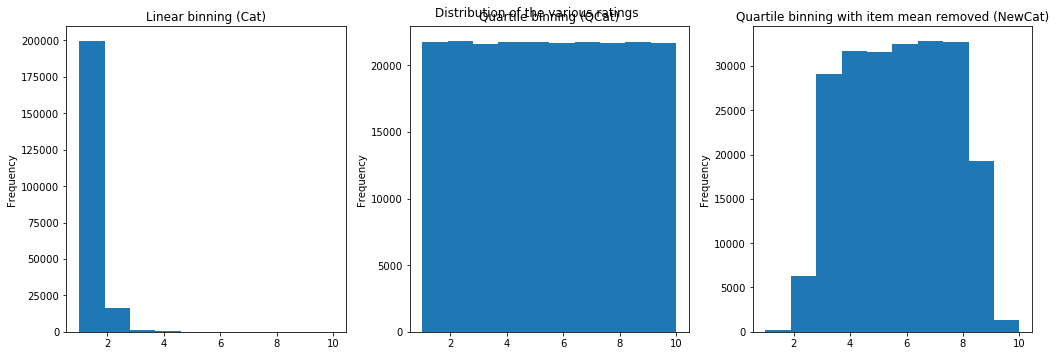

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

df_1kfamous['cat_plays'].astype(int).plot(kind='hist',ax=axs[0])
df_1kfamous['qcat_plays'].astype(int).plot(kind='hist',ax=axs[1])
df_1kfamous['new_plays'].astype(int).plot(kind='hist',ax=axs[2])

plt.suptitle('Distribution of the various ratings')
axs[0].set(title='Linear binning (Cat)')
axs[1].set(title='Quartile binning (QCat)')
axs[2].set(title='Quartile binning with item mean removed (NewCat)')

plt.tight_layout()

## Removing Users with low number of listens

Since recommending to people that don't have any information is hard, we simply choose to remove from the dataset every user that didn't listen at least 10 songs (we count the total number of plays, even if they are made on a single track).

In [7]:
# Get the number of listens per user
df_1kfamous['user_count'] = df_1kfamous.groupby('user-id').transform(lambda x : x.count())['plays']

# Filter out those who don't have at least 10
df_reduced = df_1kfamous[df_1kfamous['user_count'] > 10]

# df_reduced.to_pickle('df_reduced.pkl')

## Setup surprise datastructures

Here we simply create a train-test split, and setup the surprise datasets for the following evaluations.

In [8]:
df_test_split, df_inter = n_most_recent_track_plays_per_user(df_reduced.copy(),0.2)
df_validation_split, df_train_split = n_most_recent_track_plays_per_user(df_inter,0.2)

In [9]:
def generate_train_validation_test_set(rating, train=df_train_split , validation=df_validation_split, test=df_test_split) :
    reader = Reader(rating_scale=(1, 10))
    
    ntrainData = Dataset.load_from_df(train[['user-id', 'track-id', rating]], reader)
    nvalidationData = Dataset.load_from_df(validation[['user-id', 'track-id', rating]], reader)
    ntestData = Dataset.load_from_df(test[['user-id', 'track-id', rating]], reader)
  
    
    return ntrainData,nvalidationData,ntestData

## Defining Evaluation metrics

The following function which is arguably quite big computes for all users the evaluation metrics which we selected (artist, track) x (precision, recall, MAP).

In [10]:
def compute_precision_rec(model, user, df_train, df_valid, tracks_df):
    
    def compute_map(s):
        sums = 0
        correct = 0
        for i,v in enumerate(s):
            if v:
                sums += (correct+1)/(i+1)
                correct += 1
        return sums/len(s)

    # take only listens for current user
    filter_out = df_train[df_train['user-id'] == user]['track-id']
    
    # take only tracks listened in train set
    filtered_tracks = tracks_df[~tracks_df['musicbrainz-track-id'].isin(filter_out)]['musicbrainz-track-id']
    
    # predict for filtered tracks
    predicts = [model.predict(uid=user, iid=x).est for x in filtered_tracks]
    
    # create df of predictions
    predicts_df = pd.Series(filtered_tracks).to_frame()
    predicts_df['prediction'] = predicts
    predicts_df = predicts_df.rename(columns={0:'track-id'})
    
    # compute relevant rows
    full_df = pd.concat([df_valid, df_train])
    df_val_user  = df_valid[df_valid['user-id'] == user]
    df_full_user = full_df[full_df['user-id'] == user]
    
    # compute relevant tracks from df val
    relevant_tracks  = df_val_user[df_val_user['track-id'].isin(filtered_tracks)].sort_values(by='plays',ascending=False)['track-id']
    
    # compute relevant artists from full df
    relevant_artists = df_full_user[df_full_user['track-id'].isin(filtered_tracks)].sort_values(by='plays',ascending=False)['musicbrainz-artist-id']
    
    # compute predicted relevant tracks for user
    predicted_top = predicts_df.sort_values(by='prediction', ascending=False).head(10)['musicbrainz-track-id']
    top_artists   = tracks_df[tracks_df['musicbrainz-track-id'].isin(predicted_top)]['musicbrainz-artist-id']
    
    track_prec    =  len(set(predicted_top).intersection(set(relevant_tracks))) / len(set(predicted_top))
    artist_prec   =  len(set(top_artists).intersection(set(relevant_artists)))  / len(set(top_artists))
    
    track_rec     =  len(set(predicted_top).intersection(set(relevant_tracks))) / len(set(relevant_tracks))
    artist_rec    =  len(set(top_artists).intersection(set(relevant_artists)))  / len(set(relevant_artists))
    
    track_map     = compute_map(predicted_top.isin(relevant_tracks))
    artist_map    = compute_map(top_artists.isin(relevant_artists))
    
    return track_prec, artist_prec, track_rec, artist_rec, track_map, artist_map

def compute_metrics(model, df_train, df_valid, tracks_df):
    track_precisions  = []
    artist_precisions = []
    track_recalls     = []
    artist_recalls    = []
    track_maps        = []
    artist_maps       = []
    
    for user in tqdm(df_validation_split['user-id'].unique()):
        track_prec, artist_prec, track_rec, artist_rec, track_map, artist_map = compute_precision_rec(model,user, df_train, df_valid, tracks_df)
        track_precisions.append(track_prec)
        artist_precisions.append(artist_prec)
        track_recalls.append(track_rec)
        artist_recalls.append(artist_rec)
        track_maps.append(track_map)
        artist_maps.append(artist_map)
        
    return track_precisions, artist_precisions, track_recalls, artist_recalls, track_maps, artist_maps

## Util plotting function

Since the further experiments will used grouped violinplots, we simply create a util function to create them

In [11]:
order = ['Track Precision','Track Recall','Track MAP','Artist Precision','Artist Recall','Artist MAP']

def grouped_boxplot(ratings_df, category, figsize=(10,5),order=order):
    cols = ratings_df.columns

    exploded_df = ratings_df.apply(lambda x : list(zip(*[x[col] for col in cols])), axis=1).to_frame().explode(0)[0].apply(lambda x : pd.Series(list(x)))
    exploded_df.columns = cols
    molten_df = (exploded_df
                .reset_index()
                .rename(columns={'index': category,
                                 'track_precisions': 'Track Precision',
                                 'artist_precisions':'Artist Precision',
                                 'track_recalls':'Track Recall',
                                 'artist_recalls':'Artist Recall',
                                 'track_maps':'Track MAP',
                                 'artist_maps':'Artist MAP'
                                })
                .melt(id_vars=category, var_name='Metric', value_name='Metric Value')
                )
    
    plt.figure(figsize=figsize)
    sns.violinplot(data=molten_df, x='Metric', y='Metric Value', hue=category, cut=0, order=order, legend_out=False)
    plt.legend(loc='upper left')

# Selecting our Model

In order to select our model, we first do a selection to verify which rating returns the best relevance, and to verify how much the rating type makes a difference in the relevance.

Then, we perform the usual search to select the type of Collaborative Recommender model (SVD, SVD++, KNN, Nonnegative Matrix Factorization, Probabilistic Matrix Factorization) which gives us the best Rank based metrics. 

After having selected the model, we can finally perform another grid search to compute the best hyper-parameters for the model.

In [12]:
def save_result(result,rating, model) :
    track_precisions, artist_precisions, track_recalls, artist_recalls, track_maps, artist_maps = compute_metrics(model, df_train_split, df_validation_split, famous_tracks)
    
    result[rating]['track_precisions']  = (track_precisions)
    result[rating]['artist_precisions'] = (artist_precisions)
    result[rating]['track_recalls']     = (track_recalls)
    result[rating]['artist_recalls']    = (artist_recalls)
    result[rating]['track_maps']        = (track_maps)
    result[rating]['artist_maps']       = (artist_maps)
    return result

## Selecting the Rating

In [13]:
# code that does train test split over all three computed ratings and verifies which is the best

def rating_search():
    ratings = ['cat_plays', 'qcat_plays', 'new_plays']

    rating_results = {}

    for rating in ratings : 
        rating_results[rating] = {}
        train, validation, test = generate_train_validation_test_set(rating)

        model =  SVD(biased=False).fit(train.build_full_trainset())
        predictions = model.test(validation.build_full_trainset().build_testset())

        rating_results[rating]['rmse'] = accuracy.rmse(predictions, verbose=False)
        rating_results[rating]['mae'] = accuracy.mae(predictions, verbose=False)

        save_result(rating_results, rating, model)
        
    return rating_results

# here we only read from pickle the results instead of running the function
with open('data/rating_results.pkl', 'rb') as handle:
    rating_results = pickle.load(handle)

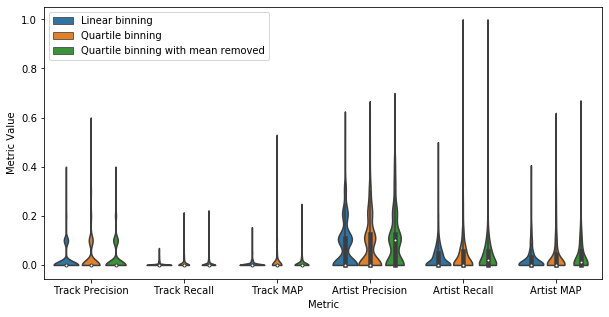

In [14]:
ratings_df = pd.DataFrame(rating_results).drop(['rmse','mae']).T
ratings_df.index = ['Linear binning', 'Quartile binning', 'Quartile binning with mean removed']

grouped_boxplot(ratings_df, 'Rating')

## Selecting the Model : Grid Search

In [15]:
def launch_grid_search(algos, algo_names,rating ='qcat_plays'):
    results_model_search = {}
    train, validation, test = generate_train_validation_test_set(rating)
    for algo, name in tqdm(zip(algos, algo_names),total=len(algos)):

        results_model_search[name] = {}
        
        # train and test algorithm.
        model =  SVD(biased=False).fit(train.build_full_trainset())
        predictions = model.test(validation.build_full_trainset().build_testset())
    
        # Compute RMSE, MAE
        results_model_search[name]['rmse'] = accuracy.rmse(predictions, verbose=False)
        results_model_search[name]['mae'] = accuracy.mae(predictions, verbose=False)
        
        save_result(results_model_search, name, model)

        
    return results_model_search


algos = [SVD(),
        SVD(biased=False),
        NMF(),
        KNNBaseline(sim_options={'user_based':True, 'name':'pearson_baseline'}),
        KNNBaseline(sim_options={'user_based':False, 'name':'pearson_baseline'}),
        CoClustering(n_cltr_u=5, n_cltr_i=20)
        ]

algo_names = ['SVD', 'PMF', 'NMF', 'User-based KNN with Baseline', 'Item-based KNN with Baseline','CoClustering']

# here we only read from pickle the results instead of running the function
with open('data/model_results.pkl', 'rb') as handle:
    results_model = pickle.load(handle)

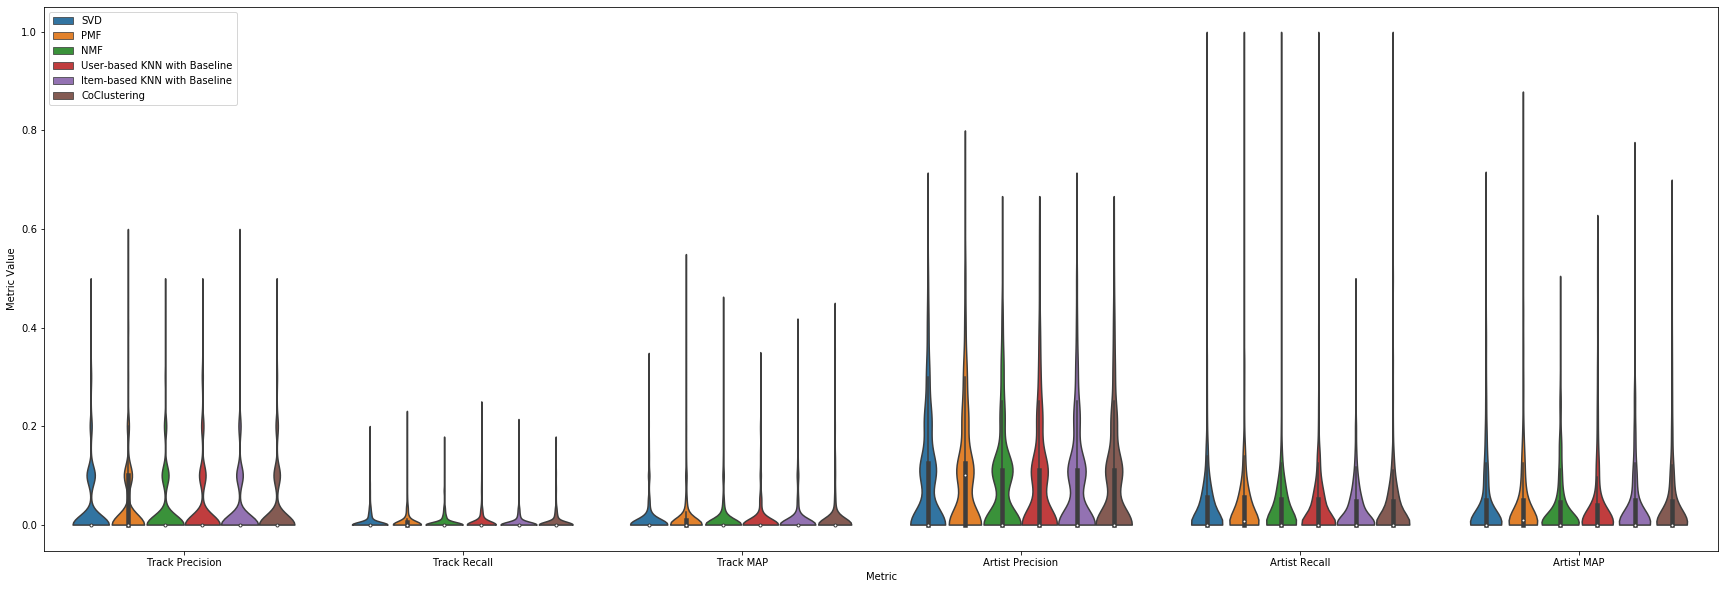

In [16]:
models_df = pd.DataFrame(results_model).drop(['rmse','mae']).T

grouped_boxplot(models_df, 'Model', figsize=(30,10))

# Implicit ALS with implicit library

The **scikit-surprise** library features a lot of different models, but since we were not very appreciative of their results, we started to look at other implementations, and one that caught our eye is the implementations from the **implicit** library, which had a try at the last.fm 360K dataset.

We used their model (implicit ALS), and applied the same BM25 weighting (with different selected hyperparams) over our Matrix of User X Tracks plays, and ended up with very decent results !

In this case we don't filter out users who have less than 10 listens. This is simply because we figured that it didn't make such a difference, so we made our life simpler by keeping them.

In [17]:
# computing the number of users and tracks to create the sparse matrix
lenusers, lentracks = df_1kfamous.catuser.nunique(), df_1kfamous.cattrack.nunique()

# creating the sparse matrix from the df
coo = scipy.sparse.coo_matrix((df_1kfamous.plays.values, (df_1kfamous.catuser.values, df_1kfamous.cattrack.values)), shape=(lenusers,lentracks))

## Metrics for grid search

Since we now use a Sparse matrix, we couldn't reuse our previous function to compute the test metrics, so we got to work and created a much more efficient function which utilizes better numpy's vectorized capabilities to compute the precision, recall and MAP.

In [18]:
def compute_test_metrics(model, coo_train, coo_test, full_df, mean_only=True):
    def compute_map(s):
        sums = 0
        correct = 0
        for i,v in enumerate(s):
            if v:
                sums += (correct+1)/(i+1)
                correct += 1
        return sums/len(s)

    results = {}

    # compute ratings
    ratings = np.where((coo_train != 0).toarray().T, -100, model.user_factors.dot(model.item_factors.T))
    test = coo_test > 0

    # keep only ratings where we have users
    valid_users = np.ravel(test.sum(axis=0) > 0)
    valid_user_inds = [i for i,b in enumerate(valid_users) if b]
    test = test[:,valid_users]
    ratings = ratings[valid_users]

    # compute datastructures for track relevance
    user_best = np.argpartition(-ratings,3,axis=1)[:,:10]
    intersect = np.take_along_axis(test.toarray().T, user_best, axis=1)
    possible_tracks = np.array(test.sum(axis=0).T)
    non_zero = possible_tracks > 0

    # compute all metrics for tracks
    results['track_precision'] = intersect.mean(axis=1)
    results['track_recall']    = (intersect.sum(axis=1)[:,np.newaxis][non_zero] / possible_tracks[non_zero])
    results['track_map']       = np.apply_along_axis(compute_map,axis=1,arr=intersect)

    # compute datastructures for artist relevance
    track_to_artist               = (full_df[['cattrack', 'musicbrainz-artist-id']]
                                     .drop_duplicates()
                                     .set_index('cattrack')
                                     ['musicbrainz-artist-id'].to_dict())

    predicted_artists             = pd.DataFrame(np.vectorize(track_to_artist.get)(user_best))
    predicted_artists['user_set'] = (full_df
                                     .query('user in @ valid_user_inds')
                                     .groupby('user')
                                     .apply(lambda x : list(x['musicbrainz-artist-id']))
                                     .reset_index()[0])

    artist_intersect = predicted_artists.apply(lambda x : pd.Series([x[i] in x['user_set'] for i in range(10)]),axis=1)

    # compute all metrics for artists
    results['artist_precision'] = artist_intersect.mean(axis=1)
    results['artist_recall']    = (artist_intersect.sum(axis=1)/predicted_artists['user_set'].apply(len))
    results['artist_map']       = np.apply_along_axis(compute_map,axis=1,arr=artist_intersect)
    
    if mean_only:
        results = {a:b.mean() for a,b in results.items()}
        
    return results

## Running Grid Search

This is the cell which we use to run the gridsearch with the implicit library. We didn't want to go overboard, so we simply performed a grid search over the number of factors of the model, as well as the two hyperparams of the weighting function, K1 and B. This is our finest gridsearch, so we already have a good idea of the best possible params.

In [19]:
def implicit_grid_search(n_factors_=[96,128,160], k1_=np.linspace(0.001,0.15,10), b_=np.linspace(0.001,0.02,10)):
    
    
    # Init data structures for tracks
    track_precisions = np.zeros((3,10,10))
    track_recalls    = np.zeros((3,10,10))
    track_maps       = np.zeros((3,10,10))
    
    # Init data structures for artists
    artist_precisions = np.zeros((3,10,10))
    artist_recalls    = np.zeros((3,10,10))
    artist_maps       = np.zeros((3,10,10))

    for a, n_factors in enumerate(n_factors_):
        for i,k1 in enumerate(k1_):
            for j,b in enumerate(b_):

                # create rating
                weighted = bm25_weight(coo.T,K1=k1,B=b).tocsr()
                weighted.nonzero()

                # create melted df 
                sparse_df = pd.DataFrame.sparse.from_spmatrix(weighted).reset_index()
                melted    = (pd.melt(sparse_df,id_vars='index', var_name='user', value_name='rating')
                             .rename(columns={'index':'track'}))
                melted    = melted[melted.rating != 0]

                # merge with df1k, train test split
                df_1kfamous_n                       = df_1kfamous.merge(melted, left_on=['catuser', 'cattrack'], right_on=['user', 'track'])
                df_test_split, df_inter             = n_most_recent_track_plays_per_user(df_1kfamous_n,0.15)
                df_validation_split, df_train_split = n_most_recent_track_plays_per_user(df_inter,0.15)

                # get coo matrix for splits
                coo_train = scipy.sparse.coo_matrix((df_train_split.rating.values, (df_train_split.catuser.values, df_train_split.cattrack.values)), shape=(lenusers,lentracks)).T
                coo_test  = scipy.sparse.coo_matrix((df_validation_split.rating.values, (df_validation_split.catuser.values, df_validation_split.cattrack.values)), shape=(lenusers,lentracks)).T

                # train model
                model = AlternatingLeastSquares(factors=n_factors, dtype=np.float32)
                model.approximate_similar_items = True
                model.fit(coo_train)

                # compute precision, recall
                results = compute_test_metrics(model, coo_train, coo_test, df_1kfamous_n)

                track_precisions[a,i,j]  = results['track_precision']
                track_recalls[a,i,j]     = results['track_recall']    
                track_maps[a,i,j]        = results['track_map']
                artist_precisions[a,i,j] = results['artist_precision']
                artist_recalls[a,i,j]    = results['artist_recall']
                artist_maps[a,i,j]       = results['artist_map']
    
    return track_precisions,track_recalls,track_maps,artist_precisions,artist_recalls,artist_maps

## Grid Search results

We used the previous function to run a gridsearch, here we simply load the results and display them

In [20]:
factors = [96,128,160]
k1      = ['{:.2f}'.format(x) for x in np.linspace(0.001,0.15,10)]
b       = ['{:.3f}'.format(x) for x in np.linspace(0.001,0.02,10)]

with open('data/gridsearch_implicit2_artist_maps.pkl', 'rb') as handle:
    artist_maps = pickle.load(handle)
    
with open('data/gridsearch_implicit2_artist_precisions.pkl', 'rb') as handle:
    artist_precisions = pickle.load(handle)
    
with open('data/gridsearch_implicit2_artist_recalls.pkl', 'rb') as handle:
    artist_recalls = pickle.load(handle)
    
with open('data/gridsearch_implicit2_track_maps.pkl', 'rb') as handle:
    track_maps = pickle.load(handle)
    
with open('data/gridsearch_implicit2_track_precisions.pkl', 'rb') as handle:
    track_precisions = pickle.load(handle)
    
with open('data/gridsearch_implicit2_track_recalls.pkl', 'rb') as handle:
    track_recalls = pickle.load(handle)

metrics = [track_precisions, track_recalls, track_maps, artist_precisions, artist_recalls, artist_maps]
metric_names = ['Track precision', 'Track recall', 'Track map', 'Artist precision', 'Artist recall', 'Artist map']

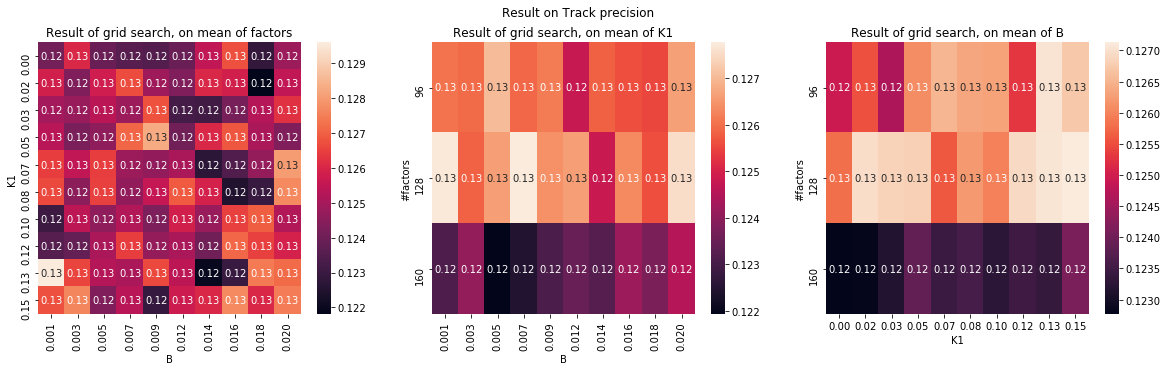

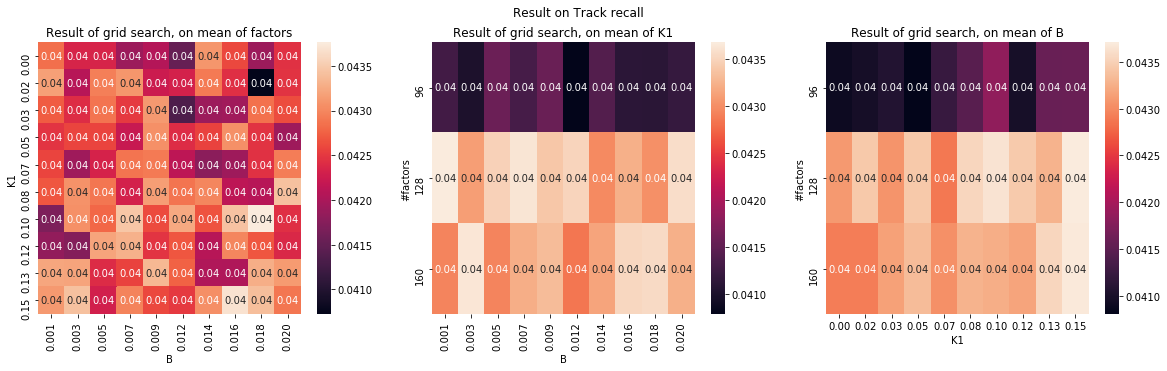

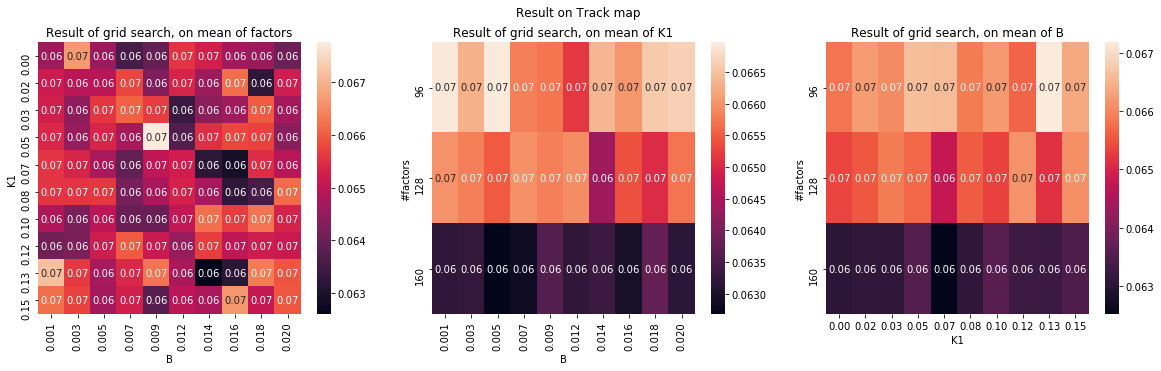

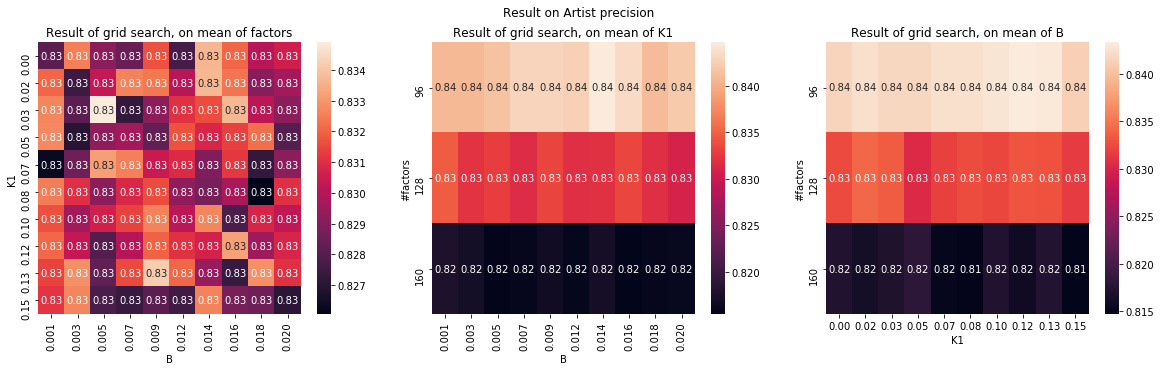

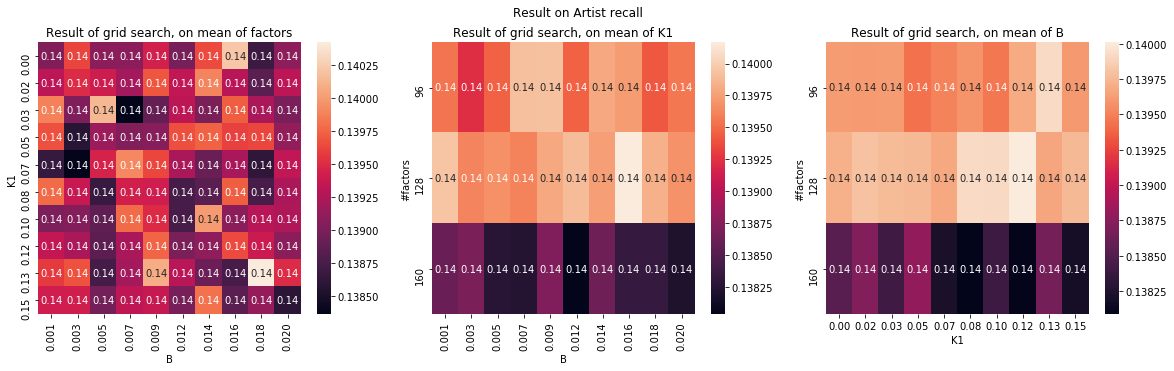

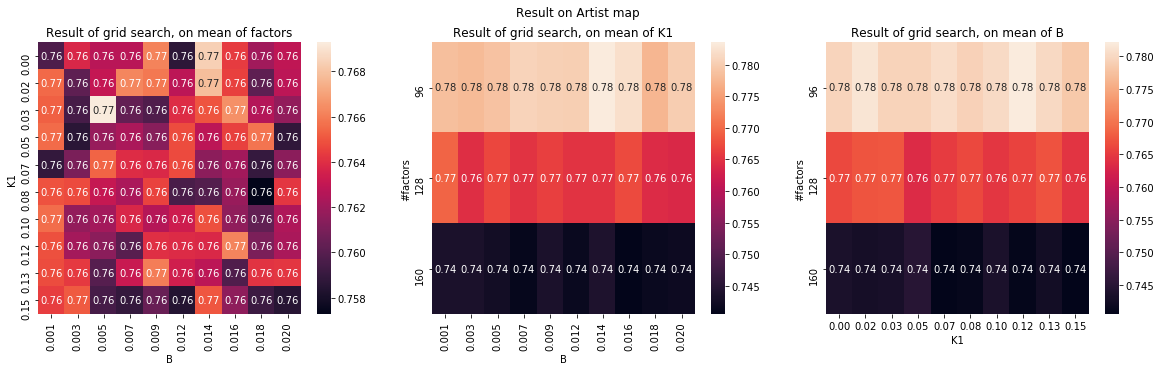

In [21]:
for i,(metric,mname) in enumerate(zip(metrics,metric_names)):
    fig, axs = plt.subplots(ncols=3, figsize=(20,5))
    
    sns.heatmap(metric.mean(axis=0),xticklabels=b, yticklabels=k1, annot=True, fmt='.2f',ax=axs[0])
    axs[0].set(xlabel='B', ylabel='K1', title='Result of grid search, on mean of factors');

    sns.heatmap(metric.mean(axis=1),xticklabels=b, yticklabels=factors, annot=True, fmt='.2f',ax=axs[1])
    axs[1].set(xlabel='B', ylabel='#factors', title='Result of grid search, on mean of K1');

    sns.heatmap(metric.mean(axis=2),xticklabels=k1, yticklabels=factors, annot=True, fmt='.2f',ax=axs[2])
    axs[2].set(xlabel='K1', ylabel='#factors', title='Result of grid search, on mean of B');

    plt.suptitle(f"Result on {mname}")
    plt.show()

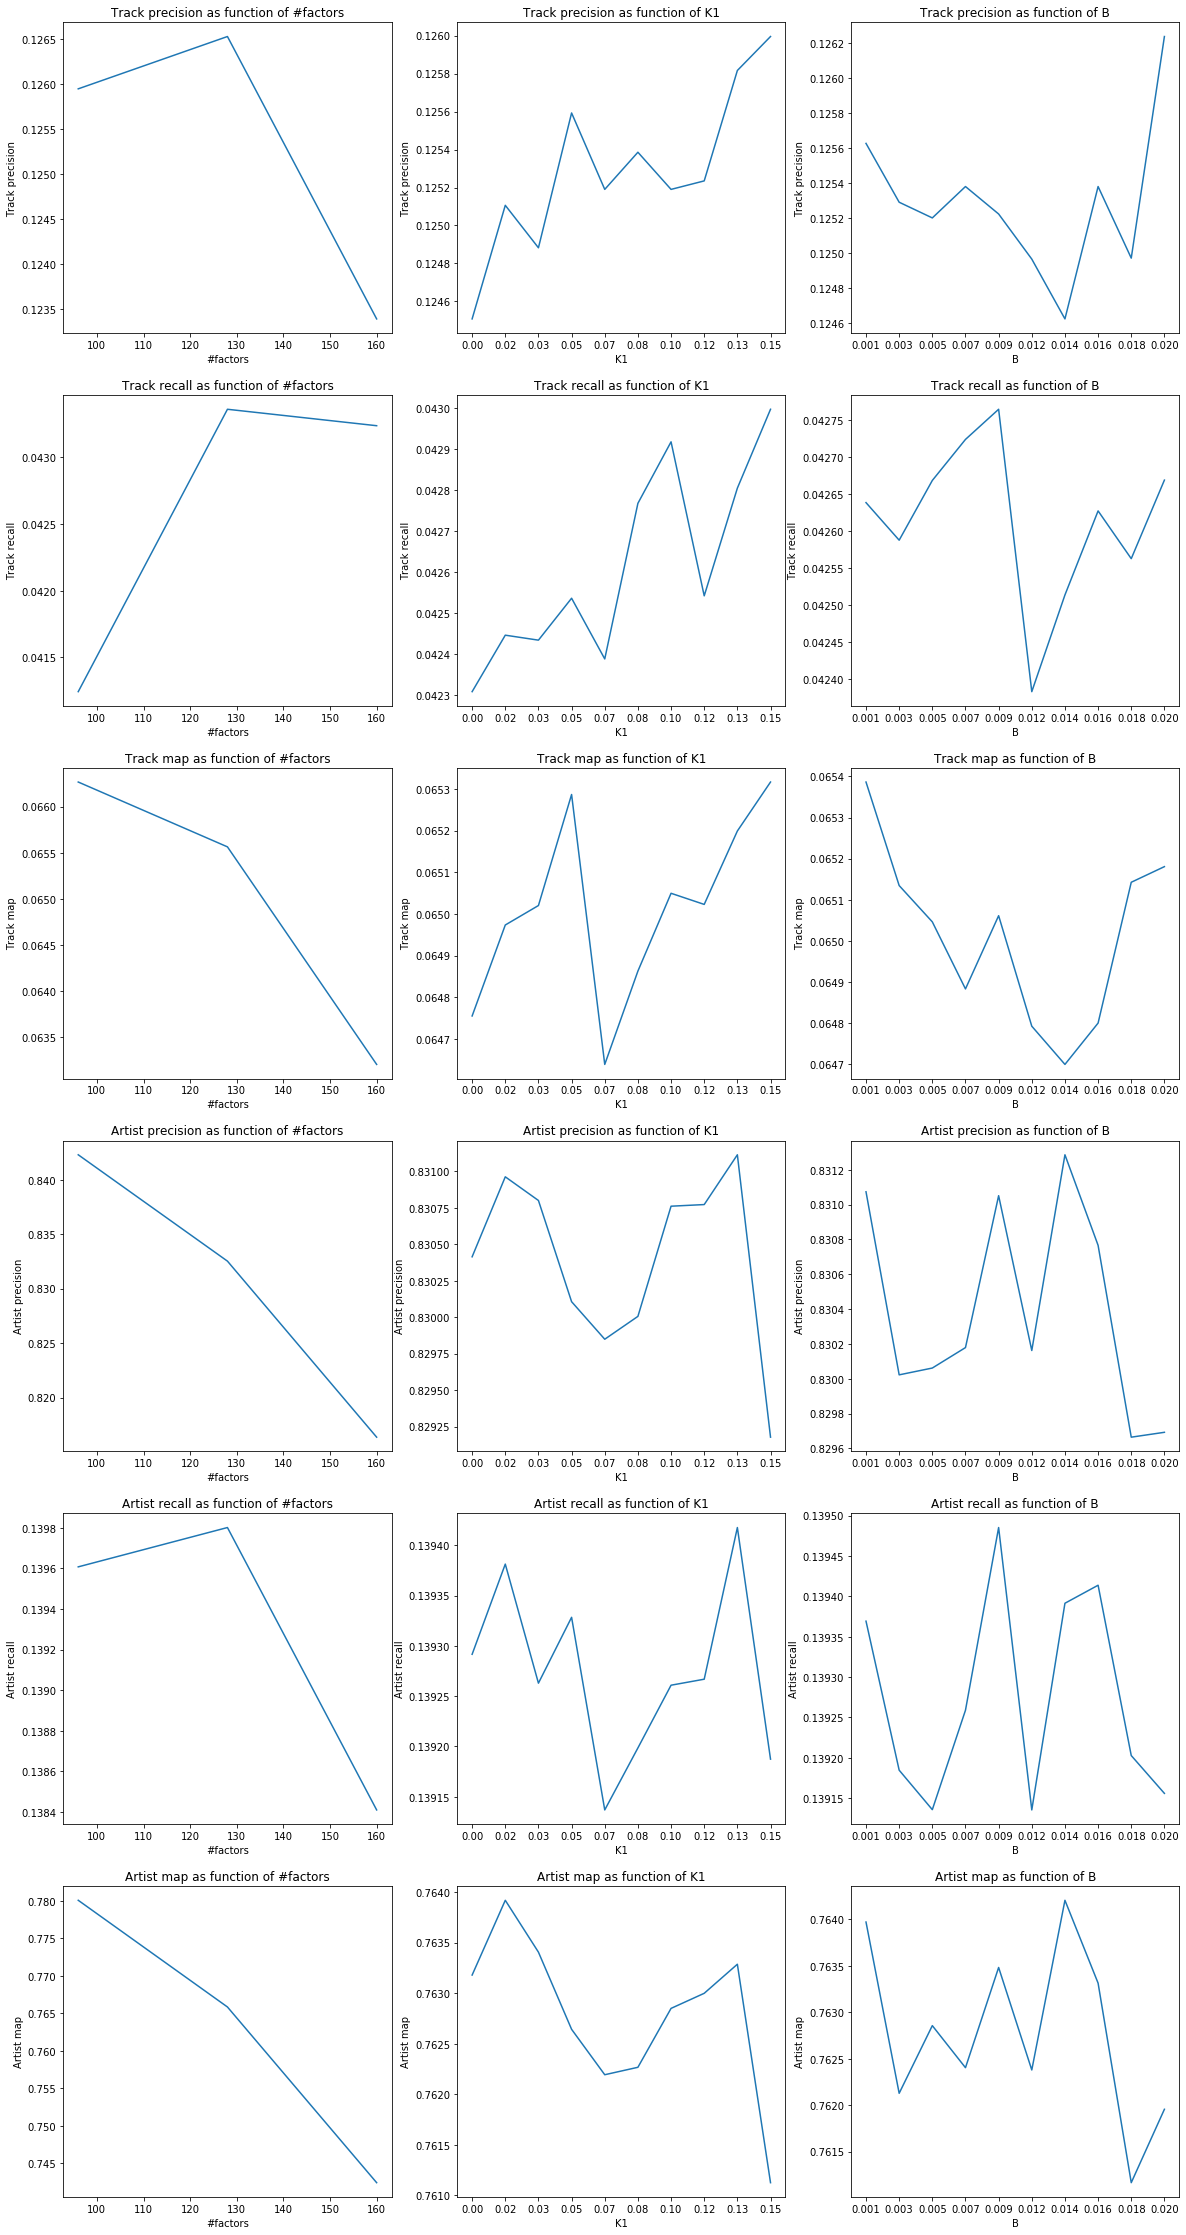

<Figure size 432x288 with 0 Axes>

In [22]:
fig, axs = plt.subplots(nrows=len(metrics), ncols=3,figsize=(20,40))

for i,(metric,mname) in enumerate(zip(metrics,metric_names)):
    axs[i][0].plot(factors, metric.mean(axis=(1,2)),label=mname)
    axs[i][0].set(xlabel='#factors', ylabel=mname, title=f'{mname} as function of #factors')    
    
    axs[i][1].plot(k1, metric.mean(axis=(0,2)))
    axs[i][1].set(xlabel='K1', ylabel=mname, title=f'{mname} as function of K1')

    axs[i][2].plot(b, metric.mean(axis=(0,1)))
    axs[i][2].set(xlabel='B', ylabel=mname, title=f'{mname} as function of B');    
plt.show()
plt.tight_layout()

## From this, we select the following hyperparameters

Those are the parameters that lead to the best results, where we mostly looked at artist relevance.

We use :
- Number of factors : 96
- K1=0.03
- B=0.005

We can now retrain our model on the complete training set (made of the previous validation + training set), and compute the metrics one last time, to create a boxplot !

In [23]:
# create rating
weighted = bm25_weight(coo.T,K1=0.03,B=0.005).tocsr()
weighted.nonzero()

# create melted df 
sparse_df = pd.DataFrame.sparse.from_spmatrix(weighted).reset_index()
melted    = (pd.melt(sparse_df,id_vars='index', var_name='user', value_name='rating')
             .rename(columns={'index':'track'}))
melted    = melted[melted.rating != 0]

# merge with df1k, train test split
df_1kfamous_n                       = df_1kfamous.merge(melted, left_on=['catuser', 'cattrack'], right_on=['user', 'track'])
df_test_split, df_train             = n_most_recent_track_plays_per_user(df_1kfamous_n,0.2)

# get coo matrix for splits
coo_train = scipy.sparse.coo_matrix((df_train.rating.values, (df_train.catuser.values, df_train.cattrack.values)), shape=(lenusers,lentracks)).T
coo_test  = scipy.sparse.coo_matrix((df_test_split.rating.values, (df_test_split.catuser.values, df_test_split.cattrack.values)), shape=(lenusers,lentracks)).T

# train model
model = AlternatingLeastSquares(factors=96, dtype=np.float32, random_state=42)
model.approximate_similar_items = True
model.fit(coo_train)

# compute precision, recall
results = compute_test_metrics(model, coo_train, coo_test, df_1kfamous_n, mean_only=False)

  0%|          | 0/15 [00:00<?, ?it/s]

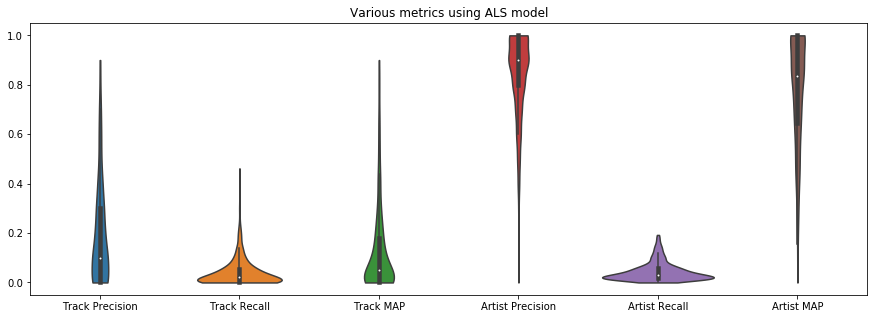

In [24]:
implicit_results = pd.DataFrame(results)
implicit_results = implicit_results.rename(columns={
    'track_precision':'Track Precision',
    'track_recall':'Track Recall',
    'track_map': 'Track MAP',
    'artist_precision': 'Artist Precision',
    'artist_recall':'Artist Recall',
    'artist_map': 'Artist MAP'
})
plt.figure(figsize=(15,5))
sns.violinplot(data=implicit_results, showfliers=False, cut=0, inner='box',order=order)
plt.gca().set(title='Various metrics using ALS model');

# Testing our Matrix Factorization with Rank-Based Metrics

## User clustering

Using the P matrix from SVD (which is the matrix of user embeddings), we try to compute a clustering of users.

Using this clustering, we will be able to compare our results based on different user groups : how do the relevance metrics react, if we have a group of similar users, a group of random users, and a group of very different users ?

#### Selecting number of clusters using Elbow method

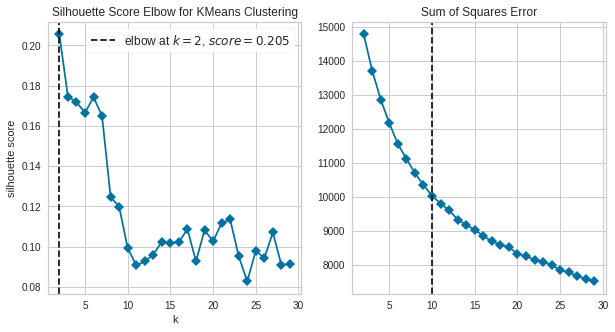

<Figure size 576x396 with 0 Axes>

In [26]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import StandardScaler 

scaled = StandardScaler().fit_transform(model.user_factors)
# compute embedding from pca
svd = TruncatedSVD(n_components=10,random_state=10)
xembed = svd.fit_transform(scaled)

#xembed = model.user_factors

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# init visualizer to find elbow between k=2 to 12
kmodel = KMeans(random_state=10)
visualizer = KElbowVisualizer(kmodel, k=(2,30), timings=False, metric='silhouette',ax=axs[0])
visualizer.fit(xembed)   

visualizer2 = KElbowVisualizer(kmodel, k=(2,30), timings=False, metric='distortion',ax=axs[1])
visualizer2.fit(xembed)   

axs[1].set(title='Sum of Squares Error')

visualizer.show()
visualizer2.show()
plt.tight_layout()

#### Fitting our model using k = 6 (selected using elbow method + silhouette)

In [27]:
# Init model with k=6
optimal_k = 6
kmodel = KMeans(n_clusters=optimal_k, random_state=100)

# Fit model
kmodel.fit(xembed)

KMeans(n_clusters=6, random_state=100)

#### Validating our clustering

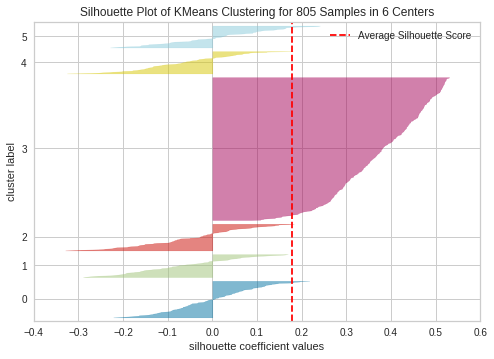

In [28]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer

visualizer = SilhouetteVisualizer(kmodel, colors='yellowbrick')
visualizer.fit(xembed)# Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

Number of users per cluster :

In [29]:
np.bincount(kmodel.labels_)

array([108,  68,  79, 419,  66,  65])

We have a decent clustering, which makes us think that we should be able to use it for selecting similar users.

It seems like the clusters are not too evenly distributed, but it makes sense : mainstream users should be more common than others. It is a bit peculiar, because a single cluster has a good average silhouette, whereas the other clusters are further from one another

#### Visualizing our clustering

In [30]:
from sklearn.manifold import TSNE
x2d = PCA(n_components=2).fit_transform(model.user_factors)

# get all real user ids
userids = range(xembed.shape[0])

# Merge back clustering labels, userid and position in 2D embedding
userlabels = pd.DataFrame({'userid':userids,'label':kmodel.labels_, 'x': x2d[:,0], 'y':x2d[:,1]} )

# Scatter plot that shows clustering of our users
fig = px.scatter(userlabels,'x','y', color='label', custom_data=['userid'])
fig.update_traces(
    hovertemplate="<br>".join([
        "x: %{x}",
        "y: %{y}",
        "user-id: %{customdata[0]}"
    ])
)

## Aggregation techniques

After reading papers on Group recommenders, we have made the choice to use the same aggregation function as defined in https://dl.acm.org/doi/10.14778/1687627.1687713 , as a function of the Average relevance, along with the Average Pair-wise Disagreement by :


$$ rel(\mathcal{G},i) = \frac{1}{|\mathcal{G}|} \sum{ relevance(u,i)}$$

$$dis(\mathcal{G},i) = \frac{2}{|\mathcal{G}|(|\mathcal{G}|-1)}\sum_{u \neq v}{|relevance(u,i) -  relevance(v,i)|}$$

$$rating(|\mathcal{G}|,i) = \gamma * rel(|\mathcal{G}|,i) + (1-\gamma)*(1-dis(|\mathcal{G}|,i)), \gamma \in [0,1] $$

Where the $\gamma$ parameter is chosen by the user at the time of the prediction.

This means that we first compute the rating for each track and each user, and then select the tracks which are in average the most liked, but that are not too much disagreed upon.

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
def predictions_from_users(model, users, train_ratings=None):
    """Predicts ratings for each user and each track given.
    
    Args:
        df: the dataframe of tracks
        users: the list of users
    Returns:
        a dataframe of size (tracks,users) of ratings provided by the svd algorithm
    
    """
    
    # compute full ratings matrix
    ratings = model.user_factors[users].dot(model.item_factors.T)
    
    # remove ratings on tracks on which we trained
    if train_ratings is not None:
        ratings = np.where((train_ratings != 0).toarray().T[users], -100, ratings)
    
    # compute prediction for all users, all tracks
    predicts_df = pd.DataFrame(ratings).T
    
    # normalize per user
    predicts_df = predicts_df.replace(-100, np.NaN)
    predicts_df = predicts_df.fillna(predicts_df.mean())
    predicts_df = pd.DataFrame(MinMaxScaler().fit_transform(predicts_df))

    return predicts_df

In [33]:
def disagreement_variance(predicts_df):
    """Computes disagreement variance given a dataframe of user ratings
    
    Args:
        predicts_df: the dataframe of ratings of size (tracks,users)
    Returns:
        a dataframe of size (tracks,1) of pairwise disagreement variance
    
    """
    values = np.zeros(predicts_df.shape[0])
    
    # iterate over all pairs of users
    for col1 in predicts_df.columns:
        for col2 in predicts_df.columns:
            if col1 != col2:
                # add difference
                values += np.abs(predicts_df[col1] - predicts_df[col2])
                
    return values * 2/(predicts_df.shape[1] * (predicts_df.shape[1] - 1))

In [34]:
def compute_group_ratings(predicts_df, relevance_coeff = 0.9, max_rating=1):
    """Computes group rating given a dataframe of user ratings
    
    Args:
        predicts_df: the dataframe of ratings of size (tracks,users)
    Returns:
        a dataframe of size (tracks,1) for the group ratings
    
    """
    # compute relevance
    average_relevance = predicts_df.mean(axis=1).to_frame('relevance') / max_rating
    
    # compute variance
    variance = disagreement_variance(predicts_df).to_frame('variance')
    
    # join back variance and relevance in a single rating
    group_ratings = average_relevance.join(variance)
    group_ratings['rating'] = (relevance_coeff*group_ratings['relevance']) + (1-relevance_coeff)*(1-group_ratings['variance'])
    return group_ratings

In [35]:
def mean_user_relevance(predicted_songs, users, tracks_df):
    
    track2artist = tracks_df[['cattrack', 'musicbrainz-artist-id']].drop_duplicates().set_index('cattrack')['musicbrainz-artist-id'].to_dict()
    user_artists = tracks_df.groupby('catuser').apply(lambda x : set(x['musicbrainz-artist-id']))

    relevances = []
    for user in users:
        artists = np.vectorize(track2artist.get)(predicted_songs)
        isin    = np.vectorize(lambda x : x in user_artists[user])(artists)
        relevances.append(isin.mean())
        
    return np.mean(relevances)

## Effect of number of users on the relevance (when sampling as many from each cluster)

In this experiment, we verify how the number of users in our group lowers the overall relevance of the playlist returned by our collaborative recommender.

This experiment is done using three types of user sampling : 

- Uniform Sampling
- All users from single cluster
- Stratified sampling across clusters (as much users from each cluster)

We hope that picking all users from the same cluster will ensure that the relevance stays good enough even when the number of users grows, but don't share the same hope for a more random sampling of users.

In [36]:
def sample_k_users(df, k, num_clusters=optimal_k):
    """Samples k users, while keeping even distribution among the clusters
    Args:
        df: Dataframe of user ids with their label given by clustering
        k: Number of users to sample
        num_clusters: Number of clusters used in sampling
    Returns:
        List of users of size k
    """    
    # select one from each cluster
    num_per = np.bincount(list(map(lambda x : x%num_clusters, np.arange(k))))

    # sample user from number
    return sum([list(df[df['label'] == i]['userid'].sample(n=x).values) for i,x in enumerate(num_per)], [])
    
users = sample_k_users(userlabels, 5)

#### Initializing all our samplers (All users from single cluster, Uniform Sampling, All users from different clusters)

In [37]:
# sample all users at random

num_clusters = len(np.unique(kmodel.labels_))

uniform_sampler       = lambda df,k : list(df['userid'].sample(n=k))
single_cluster_sampler = lambda c : (lambda df,k : list(df[df['label'] == c]['userid'].sample(n=k)))


single_cluster_samplers = [single_cluster_sampler(i) for i in range(num_clusters)]
single_cluster_names = [f'Single cluster sampler ({i})' for i in range(num_clusters)]

samplers      = [sample_k_users, uniform_sampler] + single_cluster_samplers
sampler_names = ['Uniform per cluster sampler', 'Uniform Sampler'] + single_cluster_names

#### Computing Effect of sampler on playlist relevance

For each group size and each sampler, we sample 20 groups, and compute the average relevance in the group.

In [38]:
mean_ratings = {}

all_ks = np.unique(np.geomspace(start=5, stop=np.bincount(kmodel.labels_).min(), num=5, dtype=int))
for sampler, sampler_name in zip(samplers, sampler_names):
    
    mean_ratings[sampler_name] = {}
    
    for k in tqdm(all_ks):
        mean_ratings[sampler_name][k] = []
        
        for i in range(20):
            # sample k users from the clusters
            users = sampler(userlabels,k)

            # compute predictions for the given users
            predicts_df = predictions_from_users(model, users, train_ratings=coo_train)

            # compute group ratings
            group_ratings = (compute_group_ratings(predicts_df, relevance_coeff=1)
                            .sort_values(by='rating', ascending=False)
                            .head(10).index)

            # mean rating for top_k
            mean_ratings[sampler_name][k].append(mean_user_relevance(group_ratings, users, df_1kfamous))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

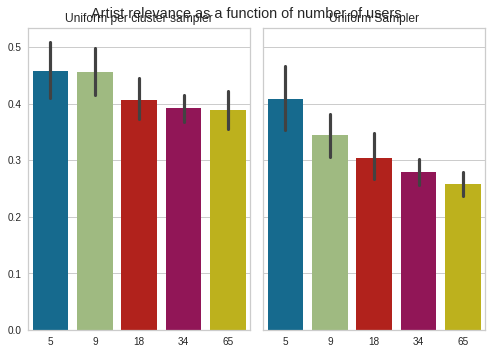

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(7,5), sharey=True)

for i,ax in enumerate(axs.flatten()):
    sns.barplot(data=pd.DataFrame(mean_ratings[sampler_names[i]]), ax=ax)
    ax.set_title(sampler_names[i])

plt.suptitle('Artist relevance as a function of number of users')
plt.tight_layout();

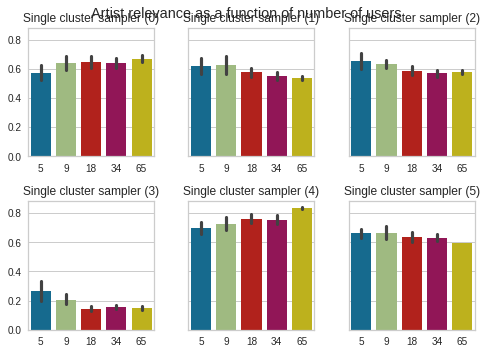

In [40]:
fig, axs = plt.subplots(ncols=3,nrows=2, figsize=(7,5), sharey=True)

for i,ax in enumerate(axs.flatten()):
    sns.barplot(data=pd.DataFrame(mean_ratings[sampler_names[2:][i]]), ax=ax)
    ax.set_title(sampler_names[2:][i])

plt.suptitle('Artist relevance as a function of number of users')
plt.tight_layout();

These results are actually overwhelmingly good ! Having a relevance close to 0.7 for uniform lower-sized groups and close to 0.6 for uniform large-sized groups makes the model look promising !

We need to keep in mind that we consider an artist to be relevant if the user listened to the artist at some point, so this metric may be a little bit too hopeful (the user may not like the artist that much, but it listened to it at least !)

An interesting result is that, while of course we expected the uniform per cluster sampler, and the general uniform sampler to give worse results, we didn't expect this ordering : The stratified per cluster sampling gives on average better results that the completely uniform sampling.

This could be a slightly random result, or due to the fact that the stratified sampling gives at least sub-groups, while the sampler had the freedom to sample users which have absolutely nothing in common with others.

## Effect of $\gamma$ coefficient on relevance

In order to select the $\gamma$ parameter, we propose to use the single $\gamma$ which gives us the best relevance on a test group. Recall that that a $\gamma$ closer to 0 acts to Minimize Disagreement, while $\gamma$ closer to  1 acts to Maximize Average relevance. In a sense, we may expect that this experiment will favor $\gamma$ closer to 1, but it is better to test this hypothesis.

Here we get the top-10 Artists for 3 users :

In [41]:
users = [617, 254, 666]
user_bests = []
for user in users:
    user_bests.append(df_1kfamous[df_1kfamous['catuser'] == user].groupby('artist-name').sum()[['plays']].sort_values(by='plays',ascending=False).head(10).reset_index()[['artist-name']])
pd.concat(user_bests, axis=1)

artist-name     artist-name                  artist-name
0            The Dandy Warhols     The Beatles                        Oasis
1                         Mgmt     Andrew Bird                  The Beatles
2  Black Rebel Motorcycle Club       Radiohead                   Pink Floyd
3                  The Beatles     Iron & Wine                  The Killers
4              The Stone Roses  Okkervil River                    The Verve
5              The Raveonettes      Deerhunter           The Rolling Stones
6                   Bloc Party    Modest Mouse                   The Smiths
7                Leonard Cohen       The Shins  Black Rebel Motorcycle Club
8                    Tom Waits      Pink Floyd                    The Clash
9    Nick Cave & The Bad Seeds          Pixies              The Stone Roses

And then we plot the proposed artists for different gamma values

In [42]:
dfs = []
for relevance_coeff in [0.5,0.8,0.9,1]:
    # compute predictions for the given users
    predicts_df = predictions_from_users(model, users, coo_train)

    # compute group ratings
    group_ratings = compute_group_ratings(predicts_df, relevance_coeff=relevance_coeff)

    # mean rating for top_k
    top10_ratings = group_ratings.sort_values(by='rating', ascending=False).head(10).index
    
    dfs.append(df_1kfamous[df_1kfamous['cattrack'].isin(top10_ratings)]['artist-name'].drop_duplicates().to_frame(f'Proposed artists in top10 tracks for gamma={relevance_coeff}').reset_index(drop=True))

pd.concat(dfs, axis=1).fillna('')

Proposed artists in top10 tracks for gamma=0.5  \
0                                    The Beatles   
1                                    The Strokes   
2                                   Joy Division   
3                                          Duffy   
4                                  Guns N' Roses   
5                                    David Bowie   
6                        Queens Of The Stone Age   

  Proposed artists in top10 tracks for gamma=0.8  \
0                                    David Bowie   
1                                    The Beatles   
2                                     The Smiths   
3                                   Joy Division   
4                                                  
5                                                  
6                                                  

  Proposed artists in top10 tracks for gamma=0.9  \
0                                    David Bowie   
1                                    The Beatles   
2                                     The Smiths   
3                                   Joy Division   
4                                                  
5                                                  
6                                                  

  Proposed artists in top10 tracks for gamma=1  
0                                  David Bowie  
1                                  The Beatles  
2                                   The Smiths  
3                                 Joy Division  
4                                               
5                                               
6

Indeed it seems like $\gamma$ values closer to 1 seems to bring in more the artists which are all common between the users, whereas when we go for lower $\gamma$ values (probably should never get below 0.5, since it would consider too much tracks where everyone agrees that they are not great).

### Now for some metrics :

For each gamma value, we use the uniform sampler to create 50 groups (groups are always the same) of 5 users.

In [43]:
gamma_ratings = {}

k = 5
sampled_groups = [uniform_sampler(userlabels,k) for x in range(50)]

for gamma in tqdm([0.5, 0.7, 0.9, 0.95, 0.97, 0.99, 1]):
    gamma_ratings[gamma] = []

    for users in sampled_groups:
        # compute predictions for the given users
        predicts_df = predictions_from_users(model, users, train_ratings=coo_train)

        # compute group ratings
        group_ratings = (compute_group_ratings(predicts_df, relevance_coeff=gamma)
                        .sort_values(by='rating', ascending=False)
                        .head(10).index)

        # mean rating for top_k
        gamma_ratings[gamma].append(mean_user_relevance(group_ratings, users, df_1kfamous))

  0%|          | 0/7 [00:00<?, ?it/s]

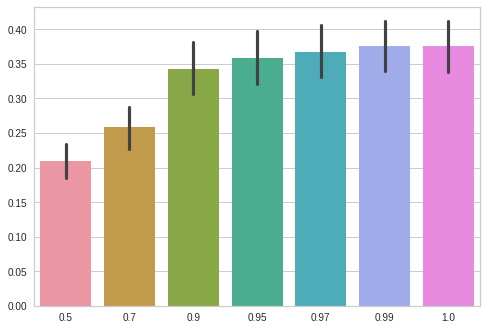

In [44]:
sns.barplot(data=pd.DataFrame(gamma_ratings))

This result makes sense, because we get the maximal average relevance, when we take $\gamma$ = 1.

When we take $\gamma$ = 1, it means we select all tracks with the best average user relevance per track.

We hoped that some $\gamma$ value slightly lower than 1 would be better in average, since it would make for a higher artist relevance for the user that is the most far away in taste compared to the rest of the group but it simply doesn't look to be the case.

However, since the Confidence Intervals overlap, it should actually be safe to pick any value of $\gamma$ between 0.9 and 1, and get meaningful results with respect to the average group relevance.

# Note : Integration in the Final Product

The python file **collaborative_recommender.py** includes a class which uses the result from the current notebook to be used in the final prototype (06 - Merged Recommender).

Here, we save the model for using in our merged recommender

In [45]:
# create rating
weighted = bm25_weight(coo.T,K1=0.03,B=0.005).tocsr()
weighted.nonzero()

# create melted df 
sparse_df = pd.DataFrame.sparse.from_spmatrix(weighted).reset_index()
melted    = (pd.melt(sparse_df,id_vars='index', var_name='user', value_name='rating')
             .rename(columns={'index':'track'}))
melted    = melted[melted.rating != 0]

# merge with df1k, train test split
df_1kfamous_n                       = df_1kfamous.merge(melted, left_on=['catuser', 'cattrack'], right_on=['user', 'track'])

# train model on full dataset
model = AlternatingLeastSquares(factors=96, dtype=np.float32)
model.approximate_similar_items = True
model.fit(coo.T)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
#df_1kfamous_n.to_pickle('data/df_1kfamous_with_ratings.pkl')

In [46]:
with open('data/implicit_model.pkl', 'wb') as handle:
    pickle.dump(model, handle)

--- 

# Non-conclusive attempt : Tensorflow recommender

In this part, we tried to adapt the **tensorflow** recommender systems built in the series to the current Dataset, but since the results with respect to relevance were not better than with the **surprise** library we scrapped this part. 

We kept it here for completeness but please don't pay attention to it.

In [47]:
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import time 
import math
import os

### Important information

We simply compute the #users, #items and #ratings, this will be used in creating the matrix for ratings later on

In [48]:
# no_users, no_items, no_ratings = (len(df_1kfamous['user-id'].unique()),
#                                   len(df_1kfamous['track-id'].unique()),
#                                   len(df_1kfamous.index))

In [49]:
# no_users, no_items, no_ratings

(805, 7938, 217449)

### Rescaling ids

Since it's easier to use category (int) codes than string ids, we map them

In [50]:
# df_1kfamous['original_user_id'] = df_1kfamous['user-id']
# df_1kfamous['original_item_id'] = df_1kfamous['track-id']
# df_1kfamous['user_id'] = df_1kfamous['user-id'].astype('category').cat.codes
# df_1kfamous['item_id'] = df_1kfamous['track-id'].astype('category').cat.codes

### Train test split

We do a very basic train test_split using only sampling (we could get better results from using timestamps but it's just a test here).

In [51]:
# from sklearn.model_selection import train_test_split
# train_ratings, test_ratings = train_test_split(df_1kfamous,test_size=0.2, random_state=42)

In [52]:
# train_ratings.shape, train_ratings['user_id'].nunique()

((173959, 20), 801)

In [53]:
# test_ratings.shape, test_ratings['user_id'].nunique()

((43490, 20), 765)

### Defining the models

Here we just copy the model definition from the series on recommender systems

In [54]:
# def create_shallow_model(no_factors, no_users, no_items):
#     # User branch
#     user_id = tf.keras.layers.Input(shape=[1], name='user_id')
#     user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
#     user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
#     # Item branch
#     item_id = tf.keras.layers.Input(shape=[1], name='item_id')
#     item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
#     item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
#     # Dot product 
#     vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
#     # Model definition
#     model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
#     return model

In [55]:
# def create_deep_model(no_factors, no_users, no_items):
#     # User branch
#     user_id = tf.keras.layers.Input(shape=[1], name='user_id')
#     user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
#     user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
#     # Item branch
#     item_id = tf.keras.layers.Input(shape=[1], name='item_id')
#     item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
#     item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
#     # Concantenation
#     vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
#     vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
#     # Backbone 
#     dense_1 = tf.keras.layers.Dense(16,name='fc3')(vectors_concat_dropout)
#     dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
#     dense_2 = tf.keras.layers.Dense(8,name='fc4', activation='relu')(dropout_1)
#     dense_2_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_2)
#     # Model definition
#     model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_2_output], name='deep_model')
#     return model

### Creating and Fitting the model

In [56]:
# no_factors=100
# model = create_deep_model(no_factors, no_users, no_items)
# model.compile(loss=tf.keras.losses.MeanSquaredError())

# model.summary()

Model: "deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       80600       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       793900      item_id[0][0]                    
_________________________________________________________________________________________

In [ ]:
# X_train = [train_ratings.user_id, train_ratings.item_id]
# y_train = train_ratings.qcat_plays
# model.fit(X_train, y_train, validation_split=0.2,epochs=20, batch_size=256, shuffle=True)

### Using the model for predictions

In [ ]:
# X_test = [test_ratings.user_id, test_ratings.item_id]
# y_test = test_ratings.qcat_plays
# y_test_pred = model.predict(X_test, batch_size=2048)

In [ ]:
# a,b = np.meshgrid(range(no_items),range(no_users))
# all_preds = model.predict([np.ravel(b), np.ravel(a)], batch_size=2048)
# all_preds = all_preds.reshape((no_users, no_items))

### RMSE Evaluation

We shouldn't use RMSE here since it's clearly not as expressive as Rank-Based but it's just simpler to print (since we scrapped the rest).

In [ ]:
# from sklearn.metrics import mean_squared_error
# print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

### Sampling a user and printing the Target and Predicted best

In [ ]:
# selected_user = 600

# predicted_best = all_preds[selected_user].argsort()[::-1][:5]

# print(df_1kfamous[df_1kfamous['item_id'].isin(predicted_best)][['artist-name','track-name']].drop_duplicates())
# df_1kfamous[df_1kfamous['user_id'] == selected_user].sort_values(ascending=False, by='plays')[['artist-name','track-name']].drop_duplicates().head(5)